# Electronic Structure Calculations using Generalized Ising Hamiltonians

Your final task is to calculate the ground state energy of a hydrogen molecule using a Generalized Ising Hamiltonian:

$$ 
H = E_0 + \sum_i h_i\sigma_i + \sum_{ij} J_{ij}\sigma_i\sigma_j
+ \sum_{ijk} K_{ijk}\sigma_i\sigma_j\sigma_k
+ \sum_{ijkl} L_{ijkl}\sigma_i\sigma_j\sigma_k\sigma_l
+ \cdots
$$

where the Hamiltonian parameters ($E_0, h_i, J_{ij}, K_{ijk}, L_{ijkl}$) will be provided to you by the `read_generalized_ising_hamiltonian` function below.

These Ising Hamiltonians were produced using the *Iterative Qubit Coupled Cluster* method (https://arxiv.org/abs/1906.11192).

The $H_2$ Ising Hamiltonian only needs 4 spins to fully describe the ground state, hence our Hamiltonian only needs a 4-point interaction at most.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from common.abstract_ising import AbstractIsing
from common.ising_animator import IsingAnimator
from common.utils import exp_decay_schedule, anneal

%matplotlib inline

In [2]:
def read_generalized_ising_hamiltonian(path):
    with open(path, "r") as f:
        f.readline()  # discard first line
        compressed_hamiltonian = [
            tuple(line.strip().split())
            for line in f.readlines()
        ]
    
    num_sites = len(compressed_hamiltonian[0][0])
    hamiltonian_terms = [np.zeros((num_sites,)*i) for i in range(num_sites+1)]

    for sites, val in compressed_hamiltonian:
        num_zs = 0
        site_nums = []
        for i, x in enumerate(sites):
            if x == 'z':
                site_nums.append(i)
                num_zs += 1

        hamiltonian_terms[num_zs][tuple(site_nums)] = float(val)

    return hamiltonian_terms

In [3]:
E0, h, J, K, L = read_generalized_ising_hamiltonian("./hamiltonians/Ising-H2-STO-3G-bk-samespin-R=0.65.inp")

First, you must write a class that describes the Generalized Ising Model given the arrays containing the Hamiltonian parameters. You will need to write a function which computes energy of the stored spin configuration (see the previous tasks for inspiration), as well as a function which computes the change in energy resulting from a single-spin-flip (you could of course use the naive approach and simply compute the energy of two spin configurations and subtract one from the other).

In [4]:
# Write a class to describe the generalized Ising Model given its Hamiltonian parameters

class GeneralizedIsingModel(AbstractIsing):
    def __init__(self, E0, h, J, K, L):
        self.E0 = E0[()]
        self.h = h
        self.J = J
        self.K = K
        self.L = L
        
        self.num_spins = h.shape[0]
        
        # initialize the spins randomly
        self.spins = 2 * (np.random.rand(self.num_spins) < 0.5) - 1
    
    def energy(self, spins=None):
        """
        Args:
            spins: a single spin configuration
        """
        if spins is None:
            spins = self.spins
            
        energy = self.E0
        energy += np.einsum('i,i->', self.h, spins)
        energy += np.einsum('ij,i,j->', self.J, spins, spins)
        energy += np.einsum('ijk,i,j,k->', self.K, spins, spins, spins)
        energy += np.einsum('ijkl,i,j,k,l->', self.L, spins, spins, spins, spins)
        
        return energy
    
    def energy_diff(self, i):
        # trivial implementation. TODO: change later to make more efficient
        E1 = self.energy()
        
        spins = np.copy(self.spins)
        spins[i] *= -1
        E2 = self.energy(spins=spins)
        
        return E2 - E1
        
    
    def rand_site(self):
        return (np.random.randint(self.num_spins),)

Next you'll run a Monte Carlo simulation for this model at some finite temperature for 1000 steps, printing out the energy of the state every so often

In [5]:
# your MC simulation here
T = 1.0
n_steps = 1000

ising = GeneralizedIsingModel(E0, h, J, K, L)

for t in range(n_steps):
    # take a look at the abstract_ising.py file to see how mc_step works
    E = ising.mc_step(T=T)
    
    if t % 50 == 0:
        print("Iteration %i, Energy=%i" % (t, E))
        
print("The final spin configuration: ", ising.spins)
print("The energy of the configuration: ", ising.energy())

Iteration 0, Energy=0
Iteration 50, Energy=0
Iteration 100, Energy=0
Iteration 150, Energy=-1
Iteration 200, Energy=0
Iteration 250, Energy=-1
Iteration 300, Energy=0
Iteration 350, Energy=0
Iteration 400, Energy=0
Iteration 450, Energy=0
Iteration 500, Energy=0
Iteration 550, Energy=0
Iteration 600, Energy=0
Iteration 650, Energy=0
Iteration 700, Energy=0
Iteration 750, Energy=0
Iteration 800, Energy=0
Iteration 850, Energy=1
Iteration 900, Energy=0
Iteration 950, Energy=0
The final spin configuration:  [ 1  1  1 -1]
The energy of the configuration:  -0.40205193171305953


Now, apply (one of) the annealing procedure(s) you came up with in the previous task to this problem to find a ground state of the system:

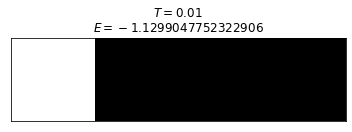

In [6]:
# your annealing code here
ising = GeneralizedIsingModel(E0, h, J, K, L)

T, _ = exp_decay_schedule(500, 100, 0.01)
animator = IsingAnimator(ising)
animator.run_animation(T)

Finally, iterate over the entire spin configuration space (this is tractable since we only have 4 spins) to find the exact ground state energy. Compare this energy to the one you found above using your annealer.

In [38]:
# exact ground state calculation
def get_exact_minimum(ising):
    dim = np.arange(2 ** ising.num_spins)
    space = ((dim[:, None] & (1 << np.arange(ising.num_spins))) > 0)
    space = 2*space.astype(int) - 1
    return np.array([ising.energy(spins) for spins in space]).min()

get_exact_minimum(ising)

-0.9332284072659004

Now, clean up your code a little, and write a for-loop that iterates over all the different values of the Hydrogen seperation distance $R$ available in the `hamiltonians` directory. 

For each $R$ you must:
- Read in the associated Ising Hamiltonian
- Perform an annealed Monte Carlo simulation to find a candidate ground state energy
- Compute the exact ground state energy
- Compare the two results

In [44]:
import os
import re

files = [file for file in os.listdir('./hamiltonians') if re.match("Ising-H2.*", file)]

energies = np.zeros(len(files))
energies_exact = np.zeros(len(files))
distances = np.zeros(len(files))

for i, file in enumerate(files):
    E0, h, J, K, L = read_generalized_ising_hamiltonian('./hamiltonians/' + file)
    ising = GeneralizedIsingModel(E0, h, J, K, L)
    
    T, _ = exp_decay_schedule(500, 100, 0.01)
    E, spins = anneal(ising, T, 10)
    
    energies[i] = E
    energies_exact[i] = get_exact_minimum(ising)
    distances[i] = float(file[30:-4])

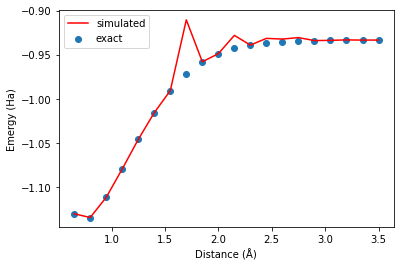

In [51]:
plt.scatter(distances, energies_exact)
plt.plot(distances, energies, color='red')
plt.xlabel("Distance (Å)")
plt.ylabel("Emergy (Ha)")
plt.legend(["simulated", "exact"])
plt.show()